## Get all imports

In [1]:
import math
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import time
from FRUFS import FRUFS
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from sklearn.metrics.cluster import normalized_mutual_info_score
from lightgbm import LGBMRegressor

## Load data

In [2]:
# Load the data into a dataframe
df = pd.read_csv("../data/ionosphere/ionosphere.data", header=None)
# Pre-process the data
df[34] = df[34].str.replace("g", '1').replace("b", '0')
# Lets check it out
display(df.head())
# Split the data into input features and target variable
data, Y = df.drop([34], axis=1), df[34].values
# Lets check out the shape of our data
print("Data shape: ", data.shape, "Target Variable shape: ", Y.shape)

num_classes = 2

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1


Data shape:  (351, 34) Target Variable shape:  (351,)


## Modelling with Decision Tree without FRUFS (no feature selection)

In [3]:
# We want to time our algorithm
start = time.time()
# Use KFold for understanding the performance of PyImpetus
kfold = KFold(n_splits=5, random_state=27, shuffle=True)
# This will hold all the accuracy scores
scores = list()
# Perform CV
for train, test in kfold.split(data):
    # Split data into train and test based on folds
    x_train, x_test = data.iloc[train], data.iloc[test]
    y_train, y_test = Y[train], Y[test]
    
    # Convert the data into numpy arrays
    x_train, x_test = x_train.values, x_test.values
    
    model_kmeans = DecisionTreeClassifier(random_state=27)
    model_kmeans.fit(x_train, y_train)
    preds = model_kmeans.predict(x_test)

    # We are going to use the NMI metric to measure the quality/performance of the clustering 
    score = accuracy_score(y_test, preds)
    print("Score:", score)
    scores.append(score)
# Compute average score
print("\n\nAverage Accuracy: ", sum(scores)/len(scores))
# Finally, check out the total time taken
end = time.time()
print("\n\nTotal Time Required (in seconds): ", end-start)

Score: 0.9436619718309859
Score: 0.9142857142857143
Score: 0.8285714285714286
Score: 0.8428571428571429
Score: 0.8714285714285714


Average Accuracy:  0.8801609657947687


Total Time Required (in seconds):  0.027924776077270508


## Modelling with FRUFS (feature selection is applied)

In [4]:
# We want to time our algorithm
start = time.time()
# Use KFold for understanding the performance of PyImpetus
kfold = KFold(n_splits=5, random_state=27, shuffle=True)
# This will hold all the accuracy scores
scores = list()
# Perform CV
for train, test in kfold.split(data):
    # Split data into train and test based on folds
    x_train, x_test = data.iloc[train], data.iloc[test]
    y_train, y_test = Y[train], Y[test]
    
    # Convert the data into numpy arrays
    x_train, x_test = x_train.values, x_test.values
    
    # Initialize the FRUFS object with your supervised algorithm of choice
    model = FRUFS(model_r=DecisionTreeRegressor(random_state=27), k=24, n_jobs=-1, verbose=0, random_state=27)
    # Train the FRUFS model and use it to downsize your data
    x_train = model.fit_transform(x_train)
    x_test = model.transform(x_test)
    
    # Finally, classify on selected features
    model_kmeans = DecisionTreeClassifier(random_state=27)
    model_kmeans.fit(x_train, y_train)
    preds = model_kmeans.predict(x_test)

    # We are going to use the NMI metric to measure the quality/performance of the clustering 
    score = accuracy_score(y_test, preds)
    print("Score:", score)
    scores.append(score)
# Compute average score
print("\n\nAverage Accuracy: ", sum(scores)/len(scores))
# Finally, check out the total time taken
end = time.time()
print("\n\nTotal Time Required (in seconds): ", end-start)

Progress bar: 100%|████████| 34/34 [00:04<00:00,  7.70it/s]


Score: 0.9154929577464789


Progress bar: 100%|███████| 34/34 [00:00<00:00, 741.13it/s]


Score: 0.9857142857142858


Progress bar: 100%|███████| 34/34 [00:00<00:00, 897.11it/s]


Score: 0.9


Progress bar: 100%|███████| 34/34 [00:00<00:00, 897.11it/s]


Score: 0.8857142857142857


Progress bar: 100%|███████| 34/34 [00:00<00:00, 873.43it/s]

Score: 0.8857142857142857


Average Accuracy:  0.9145271629778673


Total Time Required (in seconds):  4.612658977508545


# Final Results (Accuracy is used so higher is better)

### Final Accuracy using all features: 88.02 (0.028 seconds)
### Final Accuracy using PyImpetus recommended features: 91.45 (4.613 seconds)

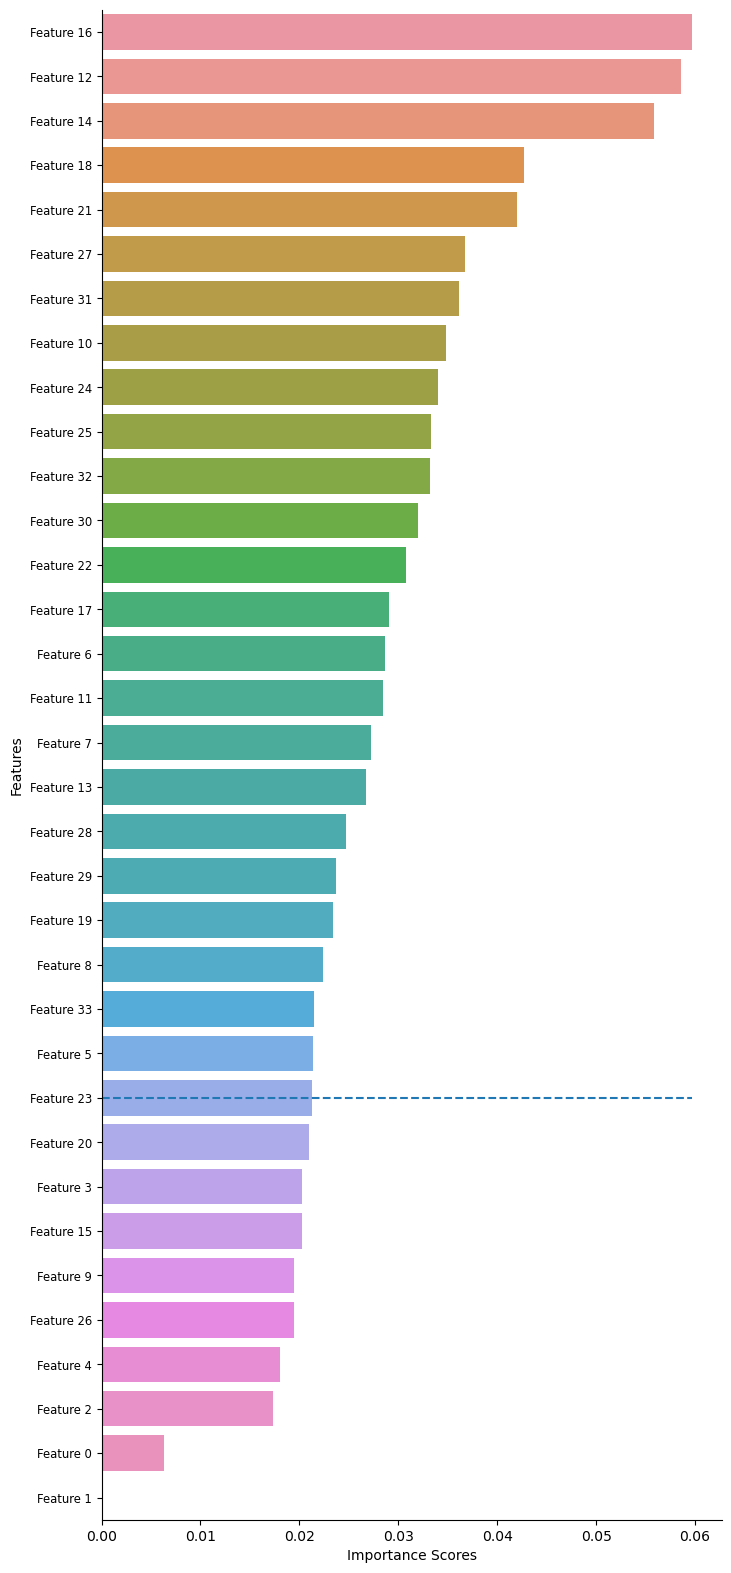

In [6]:
figure(figsize=(8, 20), dpi=100)
model.feature_importance()